## 6 予測の理由を考える

In [1]:
import warnings; warnings.simplefilter('ignore')
import sys; sys.path.append('..')

import numpy as np
import pandas as pd; pd.options.display.float_format = "{:.2f}".format
import matplotlib.pyplot as plt
import japanize_matplotlib
np.random.seed(42)

In [2]:
from util import generate_simulation_data

X_train, X_test, y_train, y_test = generate_simulation_data()

In [3]:
from sklearn.ensemble import RandomForestRegressor
from ch4.util import regression_metrics

rf = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

regression_metrics(rf, X_test, y_test)

,RMSE,R2
0,0.11,0.99


In [4]:
df = pd.DataFrame(data=X_test, columns=["X0","X1"])
df["y_pred"] = rf.predict(X_test)
df["y_pred_baseline"] = rf.predict(X_test).mean()
df.head()

,X0,X1,y_pred,y_pred_baseline
0,1.08,-0.04,0.08,0.05
1,-0.78,0.65,0.68,0.05
2,0.72,-0.37,-0.44,0.05
3,0.06,0.53,0.45,0.05
4,2.30,-0.36,-0.36,0.05


## インスタンス1のSHAPを求める

In [5]:
x = X_test[1]

# X0もX1もわからないときの予測値（すなわち、予測の平均）
E_baseline = rf.predict(X_test).mean()

# X0だけわかっているとき（すなわち、PDのように周辺化する。）
X0 = X_test.copy()
X0[:,0] = x[0]
E0 = rf.predict(X0).mean()

# X1だけがわかっているとき
X1 = X_test.copy()
X1[:,1] = x[1]
E1 = rf.predict(X1).mean()

# X0とX1の両方がわかるとき
E_full = rf.predict(x[np.newaxis, :])[0]

# 結果を出力
print(f"CASE1: X0もX1も分かっていないときの予測値 -> {E_baseline: .2f}")
print(f"CASE2: X0のみが分かっているときの予測値 -> {E0: .2f}")
print(f"CASE3: X1のみが分かっているときの予測値 -> {E1: .2f}")
print(f"CASE4: X0もX1も分かっているときの予測値 -> {E_full: .2f}")


CASE1: X0もX1も分かっていないときの予測値 ->  0.05
CASE2: X0のみが分かっているときの予測値 ->  0.05
CASE3: X1のみが分かっているときの予測値 ->  0.65
CASE4: X0もX1も分かっているときの予測値 ->  0.68


In [6]:
SHAP0 = ((E0 - E_baseline) + (E_full - E1)) / 2
SHAP1 = ((E1 - E_baseline) + (E_full - E0)) / 2

print(f"(SHAP0, SHAP1) = {SHAP0:.2f}, {SHAP1:.2f}")

(SHAP0, SHAP1) = 0.02, 0.62


In [7]:
from SHAP import ShapleyAdditiveExplanations

shap = ShapleyAdditiveExplanations(rf, X_test, ["X0","X1"])
shap.shapley_additive_explanations(id_to_compute=1)
shap.df_shap

,var_name,feature_value,shap_value
0,X0,-0.78,0.02
1,X1,0.65,0.62


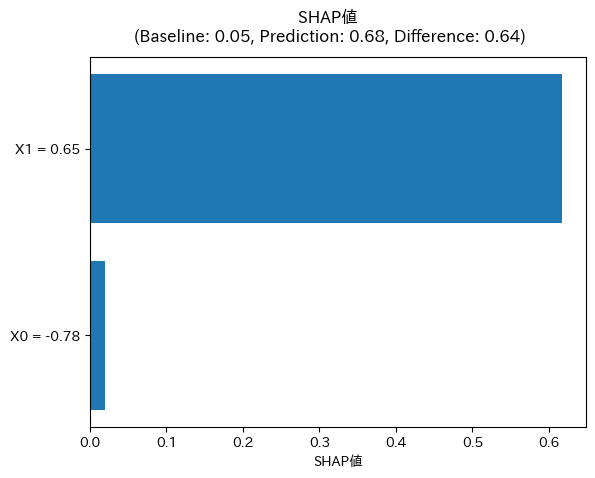

In [8]:
shap.plot()

## 6.6 実データでの分析

In [9]:
import joblib


# データと学習済みモデルを読み込む
X_train, X_test, y_train, y_test = joblib.load("../../data/boston_housing.pkl")
rf = joblib.load("../../data/boston_housing_rf.pkl")

In [10]:
import shap

explainer = shap.TreeExplainer(
    model=rf,
    data=X_test,
    feature_perturbation="interventional",
)

In [11]:
shap_values = explainer(X_test)
shap_values[0]

.values =
array([ 0.51749385,  0.00785803, -0.08193436, -0.01238695,  0.24512896,
       -0.7522285 , -0.20644507,  0.08854099,  0.02141131,  0.09107081,
        0.35612637,  0.02812565,  1.17243911])

.base_values =
21.3604

.data =
array([9.1780e-02, 0.0000e+00, 4.0500e+00, 0.0000e+00, 5.1000e-01,
       6.4160e+00, 8.4100e+01, 2.6463e+00, 5.0000e+00, 2.9600e+02,
       1.6600e+01, 3.9550e+02, 9.0400e+00])

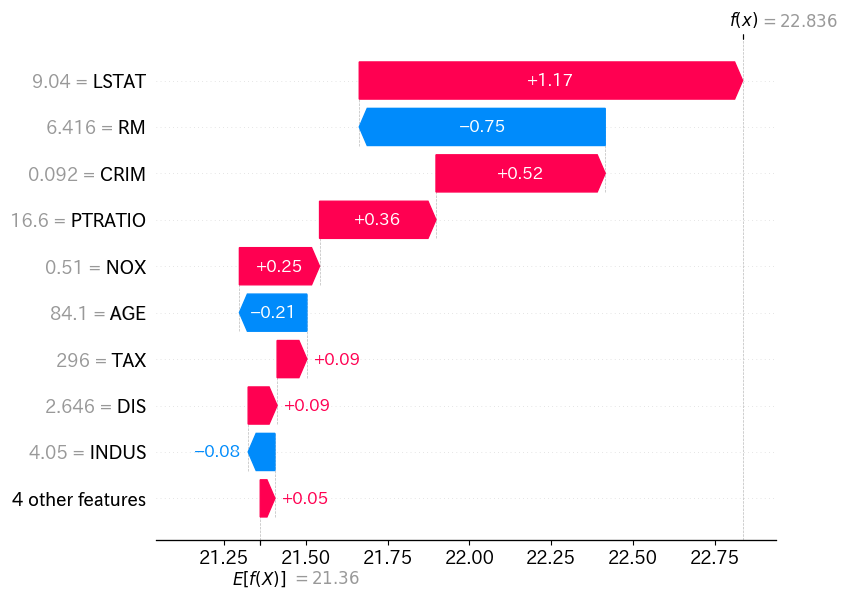

In [12]:
# インスタンス0のshapを可視化
shap.plots.waterfall(shap_values[0])

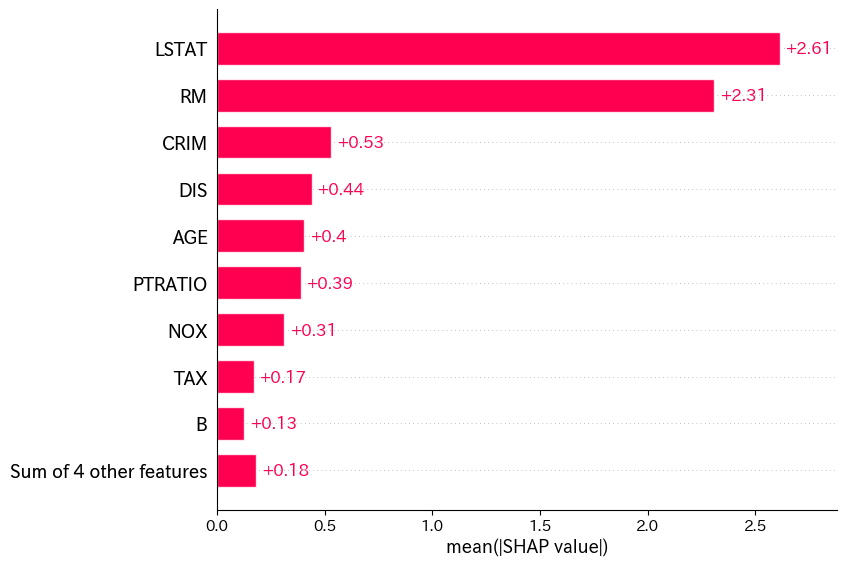

In [13]:
# 棒グラフで重要度を可視化(単なる平均値だと、符号で相殺されるので、重要度の絶対値を取る)
shap.plots.bar(shap_values=shap_values)

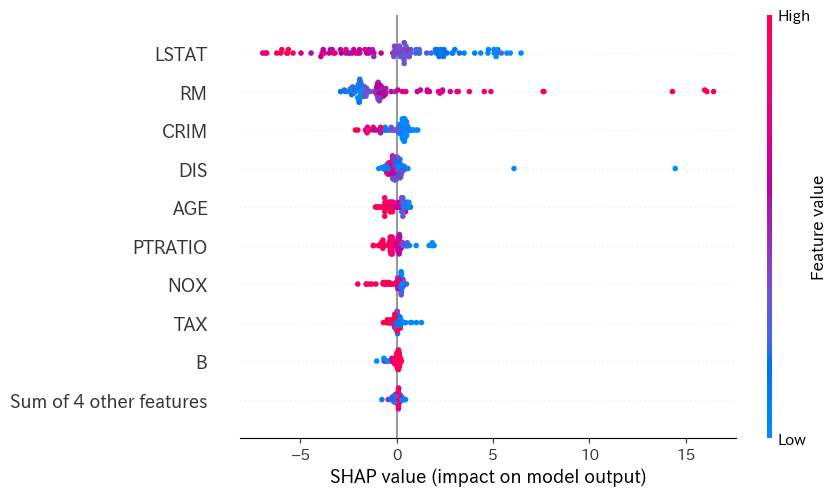

In [14]:
# beeswarm plotで重要度を可視化
shap.plots.beeswarm(shap_values)

## 6.7.2 SHAPによるPDの可視化

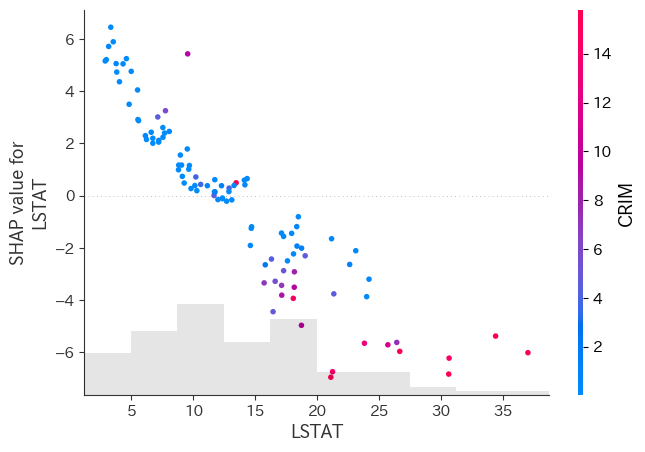

In [15]:
shap.plots.scatter(shap_values[:,"LSTAT"], color=shap_values)

## 交互作用があるときのSHAPの挙動を確認する

In [16]:
from ch5.util import generate_simulation_data

X_train, X_test, y_train, y_test = generate_simulation_data(simulation=1)

In [17]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train, y_train)
X_test = pd.DataFrame(X_test, columns=["X0","X1","X2"])

explainer = shap.TreeExplainer(rf, X_test)
shap_values= explainer(X_test)

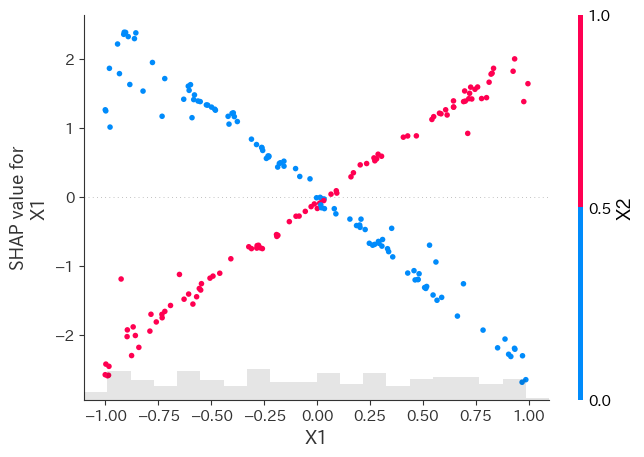

In [18]:
# SHAPによるPDの可視化
shap.plots.scatter(shap_values[:,"X1"], color=shap_values)